In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy
import pandas as pd

import sys
sys.path.append("../")
import os
from src.functional import free_gpu_cache

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.models import load_LM
import torch
from nnsight import LanguageModel
from src.utils import env_utils

# model_key = "meta-llama/Meta-Llama-3-8B-Instruct"
model_key = "meta-llama/Meta-Llama-3-70B-Instruct"

lm = load_LM(
    model_key=model_key,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 30/30 [01:01<00:00,  2.04s/it]

loaded /home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-70B-Instruct | size: 36650.535 MB


In [5]:
from src.dataset import load_worldstate_dataset
from src.functional import predict_next_token 

dataset = load_worldstate_dataset()

In [5]:
from src.functional import get_hs
from src.functional import logit_lens
from src.functional import free_gpu_cache
from src.functional import PatchSpec

from tqdm.auto import tqdm
import random
from src.utils.typing import TokenizerOutput
from src.models import prepare_input

@torch.inference_mode()
def trace_causal_influence_of_states(
    lm: LanguageModel,
    patch_qa: tuple[str | TokenizerOutput, str],  # will be patched from
    other_qa: tuple[str | TokenizerOutput, str],  # will get patched
    locations: list[tuple[str, int]], # layer_name, token_index
):
    free_gpu_cache()
    patch_q, patch_a = patch_qa
    if isinstance(patch_q, str):
        patch_q = prepare_input(prompts=patch_q, tokenizer=lm)

    last_position = (f"model.layers.{lm.config.num_hidden_layers - 1}", -1)
    pop_last_position = False
    if last_position not in locations:
        locations.append(last_position)
        pop_last_position = True

    hs = get_hs(
        lm=lm,
        input=patch_qa[0],
        locations=locations,
        return_dict=True
    )
    lm_patch_a = logit_lens(lm=lm, h=hs[last_position], k=2)[0]
    print(f"{lm_patch_a=}")

    if lm_patch_a.token.strip() != patch_a.strip():
        print(f"{lm_patch_a.token.strip()=}  !==  {patch_a.strip()=} ... skipping")
        return None

    if pop_last_position:
        locations.pop()
    
    patch_effects = {}
    for location in tqdm(locations):
        pred, track_patch_a = predict_next_token(
            lm=lm,
            input=other_qa[0],
            patches=[PatchSpec(location=location, patch=hs[location])],
            interested_tokens=[lm_patch_a.token_id],
        )
        track_patch_a = track_patch_a[lm_patch_a.token_id]
        patch_effects[location] = dict(rank=track_patch_a[0], pred=track_patch_a[1])
        free_gpu_cache()
    
    return patch_effects


In [6]:
from src.dataset import Dataset
from src.utils.typing import PredictedToken

tag_options = [
    ("a", "b"),
    ("x", "y"), 
    ("p", "q"),
]
def trace_average_causal_influence_of_states(
    lm: LanguageModel,
    dataset: Dataset,
    locations: list[tuple[str, int]],
    limit: int = 10,
) -> dict[tuple[str, int], tuple[int, PredictedToken]]:

    all_patch_effects = {loc: [] for loc in locations}
    for i in tqdm(range(limit)):
        patch_tag = random.choice(tag_options)
        other_tag = random.choice([t for t in tag_options if t != patch_tag])
        patch_qa = dataset.__getitem__(i, tags=patch_tag)
        other_qa = dataset.__getitem__(i, tags=other_tag)
        print(f"{patch_qa=}")
        print(f"{other_qa=}")
        patch_effects = trace_causal_influence_of_states(
            lm=lm,
            patch_qa=patch_qa,
            other_qa=other_qa,
            locations=[(layer_name_format.format(l), -1) for l in layer_indices],
        )
        if patch_effects is not None:
            for loc, effect in patch_effects.items():
                all_patch_effects[loc].append(effect)

    return all_patch_effects


from typing import Literal

def process_patch_effects(
    all_patch_effects: dict[tuple[str, int], list[dict[str, int]]],
    locations: list[tuple[str, int]],
    metric: Literal["prob", "logit"] = "prob",
) -> dict[tuple[str, int], float]:
    avg_effects = {loc: 0 for loc in locations}
    for loc in locations:
        for effect in all_patch_effects[loc]:
            avg_effects[loc] += getattr(effect["pred"], metric)
        avg_effects[loc] /= len(all_patch_effects[loc])
    return avg_effects

In [7]:
##################################################################################################
layer_name_format = "model.layers.{}"
limit = 10
layer_indices = list(range(0, lm.config.num_hidden_layers, 10)) + list(range(50, 60, 1))
token_idx = -1
##################################################################################################

layer_indices = sorted(list(set(layer_indices)))
locations = [(layer_name_format.format(l), -1) for l in layer_indices]

all_patch_effects = trace_average_causal_influence_of_states(
    lm=lm,
    dataset=dataset,
    locations=locations,
    limit=limit,
)


  0%|          | 0/10 [00:00<?, ?it/s]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either p or q) after the "Answer:" tag.\n\nStory: Noor is working as a barista at a busy coffee shop. Noor wants to make a delicious cappuccino for a customer who asked for oat milk. Noor grabs a milk pitcher and fills it with oat milk. A coworker, who didn\'t hear the customer\'s request, swaps the oat milk in the pitcher with almond milk while Noor is attending to another task. Noor sees her coworker swapping the milk.\n\nQuestion: Does the milk pitcher contain oat milk or almond milk?\np) The milk pitcher contains oat milk.\nq) The milk pitcher contains almond milk.\nAnswer:', 'q')
other_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when th

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:435: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


lm_patch_a=PredictedToken(token=' q', prob=0.989158034324646, logit=21.828125, token_id=2874)


 10%|█         | 1/10 [01:18<11:42, 78.09s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either p or q) after the "Answer:" tag.\n\nStory: Zara is attending an art exhibition at a local gallery in her town. Zara wants to learn more about a particular abstract painting she admires. The label next to the artwork states that the painting is the work of a famous artist, and Zara reads the label carefully. A gallery staff member, realizing there was a mix-up, changes the label with the correct information attributing the painting to an emerging artist instead. Zara reads the updated label carefully.\n\nQuestion: Is the painting the work of a famous artist or an emerging artist?\np) The painting is the work of an emerging artist.\nq) The painting is the work of a famous artist.\nAnswer:', 'p')
other

 20%|██        | 2/10 [02:42<10:52, 81.56s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either p or q) after the "Answer:" tag.\n\nStory: Carlos is a farmer in a small village in Mexico, tending to his cornfield. He wants to irrigate his crops by opening a water valve connected to a nearby river. Carlos closed the valve the previous evening. During the night, heavy rainfall caused the river to overflow, opening the valve and flooding the cornfield. Carlos sees the flooded cornfield.\n\nQuestion: Is the water valve closed or open?\np) The water valve is open.\nq) The water valve is closed.\nAnswer:', 'p')
other_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer

 30%|███       | 3/10 [04:06<09:39, 82.82s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either a or b) after the "Answer:" tag.\n\nStory: Kofi is a fisherman from a small village in Ghana. He wants to catch enough fish today to provide for his family and sell the surplus at the market. Kofi repaired his fishing net last night. While Kofi is away from his boat, a group of monkeys comes and plays with the fishing net, tearing it apart. Kofi observes the monkeys damaging his fishing net.\n\nQuestion: Is Kofi\'s fishing net in good condition or torn apart?\na) The fishing net is in good condition.\nb) The fishing net is torn apart.\nAnswer:', 'b')
other_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that ch

 40%|████      | 4/10 [05:31<08:22, 83.78s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either a or b) after the "Answer:" tag.\n\nStory: Azola is a teacher at a small school in rural China. She wants to surprise her students with a new book for the school library. Azola got a notification from Amazon stating that the package containing the book was left at her doorstep. A gust of wind blows the package off her doorstep, and a neighbor replaces it with a different package containing a hand-knit scarf. Azola witnesses the package swap.\n\nQuestion: Does the package contain the book Azola ordered or a hand-knit scarf?\na) The package contains a hand-knit scarf.\nb) The package contains the book Azola ordered.\nAnswer:', 'a')
other_qa=('Instruction: Keep track of people\'s knowledge defined in t

 50%|█████     | 5/10 [06:53<06:55, 83.03s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either p or q) after the "Answer:" tag.\n\nStory: Ravi is a farmer in a small Indian village, tending to his mango orchard. Ravi wants to harvest ripe mangoes to sell at the local market. He notices a mango tree with a heavy branch laden with ripe mangoes. A mischievous monkey comes along and eats all the ripe mangoes on the branch while Ravi is gathering his harvesting tools. Ravi sees the monkey eating the ripe mangoes.\n\nQuestion: Does the branch have ripe mangoes or no ripe mangoes?\np) The branch has no ripe mangoes.\nq) The branch has ripe mangoes.\nAnswer:', 'p')
other_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an 

 60%|██████    | 6/10 [08:14<05:29, 82.44s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either p or q) after the "Answer:" tag.\n\nStory: Kofi is a chef at a popular Ghanaian restaurant. Kofi wants to prepare a traditional groundnut soup for the dinner menu. Kofi adds a small container of peanut butter to the soup pot on the stove. An apprentice chef, mistakenly thinking it was a seasoning paste, removes the peanut butter from the soup and replaces it with tomato paste. Kofi notices the apprentice chef swapping the ingredients.\n\nQuestion: Does the soup contain peanut butter or tomato paste?\np) The soup contains tomato paste.\nq) The soup contains peanut butter.\nAnswer:', 'p')
other_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated onl

 70%|███████   | 7/10 [09:42<04:12, 84.18s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either a or b) after the "Answer:" tag.\n\nStory: Kael is a farmer in a remote village in the Andes. Kael wants to plant a new crop of high-altitude potatoes in one of his terraced fields. The soil in the field appears rich and well-fertilized. Overnight, heavy rainfall washes away much of the fertile soil, leaving mostly rocky dirt behind. Kael notices the change in the soil after the rainfall.\n\nQuestion: Is the soil rich and well-fertilized or mostly rocky dirt?\na) The soil is mostly rocky dirt.\nb) The soil is rich and well-fertilized.\nAnswer:', 'a')
other_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that ch

 80%|████████  | 8/10 [11:03<02:46, 83.08s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either x or y) after the "Answer:" tag.\n\nStory: Farhan is a street food vendor in a bustling market in Istanbul. Farhan wants to prepare a delicious chicken shawarma wrap for a customer who asked for extra garlic sauce. Farhan takes a bottle of garlic sauce from the shelf and pours it onto the shawarma wrap. His assistant, who is busy preparing a different wrap, accidentally swaps the garlic sauce with a bottle of hot sauce, and Farhan unknowingly pours the hot sauce onto the shawarma wrap. Farhan notices the sauce swap.\n\nQuestion: Does the sauce Farhan poured contain garlic sauce or hot sauce?\nx) The sauce Farhan poured is hot sauce.\ny) The sauce Farhan poured is garlic sauce.\nAnswer:', 'x')
other_

 90%|█████████ | 9/10 [12:30<01:24, 84.30s/it]

patch_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either a or b) after the "Answer:" tag.\n\nStory: Abhay is a young farmer in a small Indian village. He wants to water his crops with the water stored in a large clay pot. Abhay checks the water level and sees that the pot is full. Unbeknownst to him, a hole in the bottom of the pot has caused the water to leak out, leaving the pot empty. Abhay notices the hole and the water leaking out.\n\nQuestion: Is the pot full of water or empty?\na) The pot is full of water.\nb) The pot is empty.\nAnswer:', 'b')
other_qa=('Instruction: Keep track of people\'s knowledge defined in the story. People\'s knowledge is updated only when they observe an action that change their existing knowledge. To answer the question fol

100%|██████████| 10/10 [13:58<00:00, 83.84s/it]


In [15]:
avg_effects = process_patch_effects(all_patch_effects, locations, metric="prob")

Text(0, 0.5, 'p(ans)')

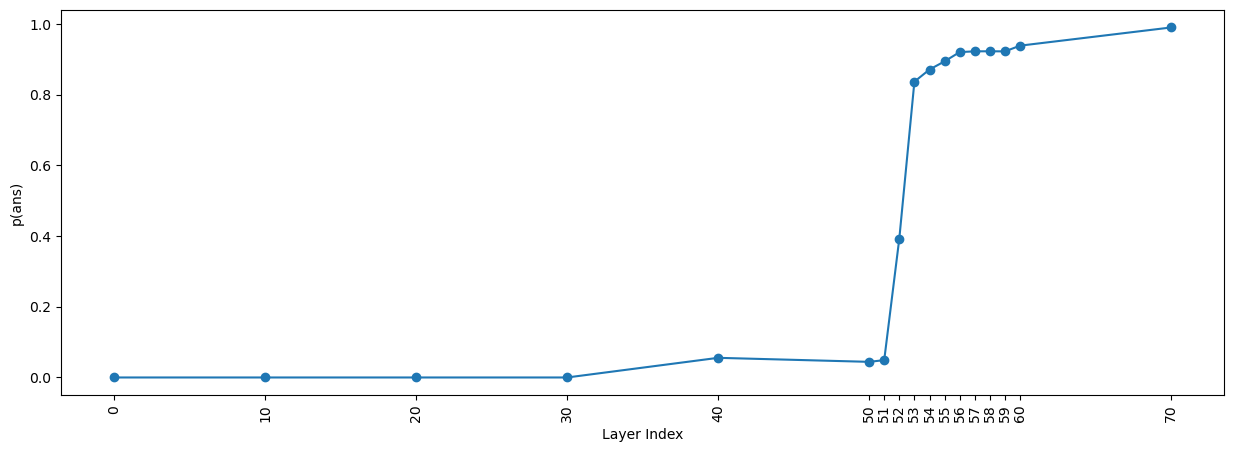

In [16]:
import matplotlib.pyplot as plt

keys = [
    int(layer.split(".")[-1]) for layer, tok_idx in avg_effects.keys()
]
plt.figure(figsize=(15, 5))
plt.plot(keys, avg_effects.values(), marker="o")
plt.xticks(keys, rotation=90)
plt.xlabel("Layer Index")
plt.ylabel("p(ans)")

## Check Attention Matrix

In [48]:
from dataclasses import dataclass, fields
from dataclasses_json import DataClassJsonMixin
import numpy as np
from src.functional import prepare_input
from src.utils.typing import TokenizerOutput

@dataclass(frozen=False)
class AttentionInformation(DataClassJsonMixin):
    tokenized_prompt: list[str]
    attention_matrices: np.ndarray

    def _init__(self, prompt: str, tokenized_prompt: list[str], attention_matrices: torch.tensor):
        assert len(tokenized_prompt) == attention_matrices.shape[-1], "Tokenized prompt and attention matrices must have the same length"
        assert len(attention_matrices.shape) == 4, "Attention matrices must be of shape (layers, heads, tokens, tokens)"
        assert attention_matrices.shape[-1] == attention_matrices.shape[-2], "Attention matrices must be square"

        self.prompt = prompt
        self.tokenized_prompt = tokenized_prompt
        self.attention_matrices = attention_matrices

    def get_attn_matrix(self, layer: int, head: int) -> torch.tensor:
        return self.attention_matrices[layer, head]

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

@torch.inference_mode()
def get_attention_matrices(
    input: str | TokenizerOutput, 
    lm: LanguageModel,
    value_weighted: bool = False
) -> torch.tensor:
    """
    Parameters:
        prompt: str, input prompt
        mt: ModelandTokenizer, model and tokenizer
        value_weighted: bool. 
            - False => will reuturn attention masks for each key-value pair (after softmax). This is the attention mask actually produced inside the model
            - True => will consider the value matrices to give a sense of the actual contribution of source tokens to the target token residual.
    Returns:
        attention matrices: torch.tensor of shape (layers, heads, tokens, tokens)
    """
    # ! doesn't support batching yet. needed in this project?
    if isinstance(input, str):
        input = prepare_input(prompts=input, tokenizer=lm)
    else:
        assert isinstance(input, TokenizerOutput), "input must be either a string or a TokenizerOutput object"
    output = lm._model(**input, output_attentions=True) # batch_size x n_tokens x vocab_size, only want last token prediction
    attentions = torch.vstack(output.attentions) # (layers, heads, tokens, tokens)
    if value_weighted:
        values = torch.vstack([output.past_key_values[i][1] for i in range(lm.config.num_hidden_layers)]) # (layers, heads, tokens, head_dim)
        values = repeat_kv(values, n_rep = 8)
        print(f"{attentions.shape=} | {values.shape=}")
        attentions = torch.einsum("abcd,abd->abcd", attentions, values.norm(dim=-1))
    return AttentionInformation(
        tokenized_prompt=[lm.tokenizer.decode(tok) for tok in input.input_ids[0]] , 
        attention_matrices=attentions.detach().cpu().to(torch.float32).numpy()
    )

In [72]:
question, answer = dataset.__getitem__(22, tags=("a", "b"))
print(question)
print(answer)

Instruction: Keep track of people's knowledge defined in the story. People's knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option (either a or b) after the "Answer:" tag.

Story: Luka is a gardener working in a beautiful park in the middle of the city. Luka wants to water the plants in the park to ensure they stay healthy and vibrant. The sky is cloudy, and Luka assumes that it might rain soon. However, the wind picks up and blows the clouds away, revealing a bright and sunny sky. Luka notices the clouds clearing and the sun shining.

Question: Will it rain soon, or has the weather become sunny?
a) The weather has become sunny.
b) It will rain soon.
Answer:
a


In [73]:
# question = "A quick brown fox"
inputs = prepare_input(prompts=question, tokenizer=lm)
attn = get_attention_matrices(
    input=inputs,
    lm = lm,
    value_weighted=True
)
attn.attention_matrices.shape

attentions.shape=torch.Size([80, 64, 175, 175]) | values.shape=torch.Size([80, 64, 175, 128])


(80, 64, 175, 175)

In [74]:
layer = 53
q_index = -1
remove_bos = False
start_idx = 1 if remove_bos else 0
avg_attn_module_matrix = torch.Tensor(attn.attention_matrices[layer]).mean(dim=0)[-1]
avg_attn_module_matrix.shape

torch.Size([175])

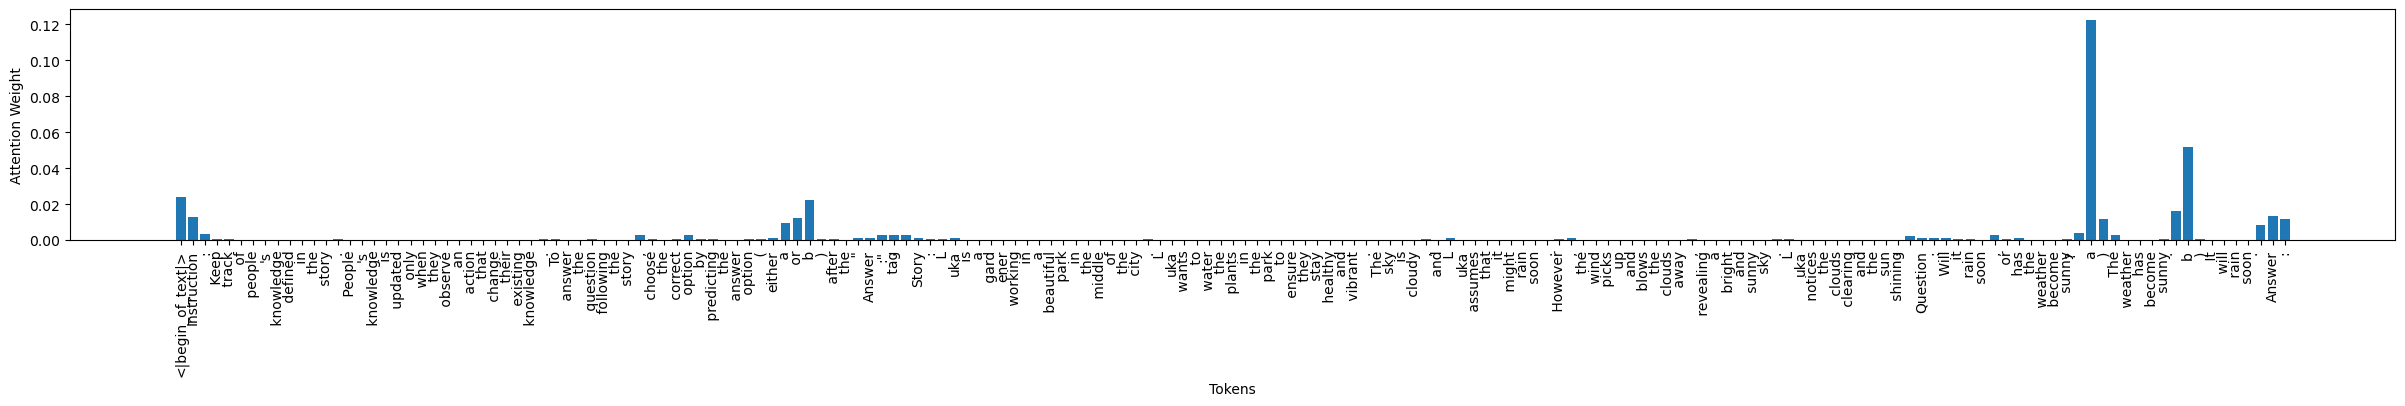

In [75]:
from matplotlib import pyplot as plt
plt.figure(figsize=(30, 3))
plt.bar(range(len(avg_attn_module_matrix[start_idx: ])), avg_attn_module_matrix[start_idx: ])
plt.xlabel("Tokens")
plt.ylabel("Attention Weight")
plt.xticks(range(len(attn.tokenized_prompt[start_idx : ])), attn.tokenized_prompt[start_idx : ], rotation=90)
plt.show()